# <center>Classifying Songs in Spotify Playlists</center>

__<center>Capstone Project for IBM Data Science Professional Certificate Specialization</center>__

__<center>by Tauno Tanilas - 2019</center>__

## 1. Introduction

This is the Capstone Project for [IBM Data Science Professional Certificate](https://www.coursera.org/specializations/ibm-data-science-professional-certificate?recoOrder=4&utm_medium=email&utm_source=recommendations&utm_campaign=recommendationsEmail~recs_email~2019-01-07) course. The subject of final project in this course is left to the author's choice. I decided to apply my acquired knowledge into the field of Data Classification and implement it on the data available in Spotify platform.

__Business problem__
- Understand the user's needs and preferences in evaluating musical tracks.
- Knowing these characteristics, provide better services.

__Target audience__
- Audio streaming providers.
- Any person willing to get insights about using classification modeling in solving machine learning problems.

__Main goals__
- Determine characteristics that define the user's musical taste.
- Using these characteristics compare the music user likes or dislikes.
- Create a predictive model on whether user likes or dislikes a song.
- Determine the main musical genres that are in user’s preferences.  
- Using Foursquare API, construct a map of accommodation options in one of the selected concert places.

## 2. Data

The data set is constructed from the Spotify playlists that I have created for myself. There are 80 playlists in total - 45 liked and 25 disliked for training and 10 for evaluation. Liked playlists are labeled as 'GOOD' and disliked as 'BAD'. For later evaluation purposes a separate file is for ten different musical genres that contain tracks that were not used in training stage.

To get the info of playlists tracks and the audio features of them, I used the Spotipy API. The data used for modeling is described by the following ten audio features:

- __Acousticness:__ A measure from 0.0 to 1.0 of whether the track is acoustic.  
- __Energy:__ A measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.  
- __Danceability:__ Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.  
- __Instrumentalness:__ Predicts whether a track contains no vocals. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content.  
- __Liveness:__ Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.  
- __Loudness:__ The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track. Values typical range between -60 and 0 db.  
- __Speechiness:__ Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talkshow, audio book, poetry), the closer to 1.0 the attribute value.  
- __Tempo:__ The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.  
- __Valence:__ A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).  
- __Duration:__ The duration of the track in milliseconds.  

### 2.1. Data Acquiring

[Spotipy](https://spotipy.readthedocs.io/en/latest/#installation) is a lightweight Python library for the Spotify Web API. With Spotipy you get full access to all of the music data provided by the Spotify platform.

Install missing libraries.

In [ ]:
# uncomment for execution
#!pip install spotipy
#!pip install scikit-plot
#!pip install styleframe
#!conda install -c conda-forge geopy --yes

Import required libraries.

In [1]:
# data downloading
import spotipy
import spotipy.util as util
import json
import requests

# data preprocessing
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np

# data visualization
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from matplotlib.ticker import PercentFormatter
import seaborn as sns
import scikitplot as skplt
import folium
from geopy.geocoders import Nominatim

# data normalization and splitting
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# metrics
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc

# algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC

Declare the functions that are needed for getting the user's Spotify data via Spotipy API.

In [16]:
def get_spotipy_authorization_tokens():
    """Read from file authorization tokens needed for making connection to the Spotipy API."""
    with open('datasets/spotify_authorization.json', 'r') as f:
        sp_authorization_tokens = json.load(f)
    return sp_authorization_tokens

In [17]:
def create_spotipy_connection(authorization_tokens):
    """
    Create connection to Spotipy API.
    
    :param authorization_tokens: authorization tokens needed for creating connection.
    :return: Connection token.
    """
    try:
        token = util.prompt_for_user_token(authorization_tokens.get('username'), 
                                           authorization_tokens.get('scope'),
                                           client_id = authorization_tokens.get('client_id'),
                                           client_secret = authorization_tokens.get('client_secret'),
                                           redirect_uri = authorization_tokens.get('redirect_uri'))
        return token
    except:
        return ("")

In [18]:
def get_selected_playlists(rating):
    """
    Read playlist names from specified file.
    
    :param rating: String to distinguish if playlist names are read from liked, disliked or genres playlist files.
    :return: List of playlist names.
    """
    if rating == 'GOOD':
        selected_playlist = pd.read_csv("datasets/liked_playlists.csv", encoding='utf-8', sep="\t")    
    else:
        selected_playlist = pd.read_csv("datasets/disliked_playlists.csv", encoding='utf-8', sep="\t")
    return list(selected_playlist['PLAYLIST_TITLE'])

In [19]:
def get_user_playlists():
    """Returns all playlists for a user who created connection."""
    total_limit = 100
    chunk_limit = 50
    offset_ind = 0
    user_playlists_dict = {}
    
    if sp_conn_token:
        while offset_ind <= total_limit:
            sp = spotipy.Spotify(auth=sp_conn_token)
            results = sp.current_user_playlists(limit=chunk_limit, offset=offset_ind)
            
            for item in results['items']:
                user_playlists_dict[item['id']] = item['name']
            offset_ind = offset_ind + chunk_limit
    else:
        print("Can't get token for", username)
    return user_playlists_dict

In [20]:
def get_playlist_tracks(username, playlist_id, all_tracks):
    """
    Finds musical tracks that are recorded under specified user’s playlist.
    
    :param username: Username of user who created connection.
    :param playlist_id: ID of playlist.
    :param all_tracks: Boolean to distinguish if all playlist’s tracks are returned or only the first one.
    :return: Dictionary containing the combination of track and artist names.
    """
    total_limit = 500
    chunk_limit = 100
    offset_ind = 0
    playlist_tracks_dict = {}
    
    if sp_conn_token:
        while offset_ind <= total_limit:
            sp = spotipy.Spotify(auth=sp_conn_token)
            if all_tracks==True:
                results = sp.user_playlist_tracks(username, playlist_id, limit=chunk_limit, offset=offset_ind)
            else:
                results = sp.user_playlist_tracks(username, playlist_id, limit=1, offset=0)
            for item in results['items']:
                try:
                    track = item['track']
                    dict_key = track['name'] + ' - ' + track['artists'][0]['name']
                    playlist_tracks_dict[dict_key] = {'artist': track['artists'][0]['name'], 
                                                      'title': track['name']}
                except:
                    continue
            offset_ind = offset_ind + chunk_limit
    else:
        print("Can't get token for", username)
    return playlist_tracks_dict

In [21]:
def get_audio_features(tracks_dict):
    """
    Finds audio features that describe musical tracks.
    
    :param tracks_dict: Dictionary containing the combination of track and artist names.
    :return: Dictionary containing combination of track and artist names and their audio features.
    """
    sp = spotipy.Spotify(auth=sp_conn_token)
    audio_features_df = pd.DataFrame()
    
    for dict_key, dict_value in tracks_dict.items():
        artist = dict_value.get('artist')
        title = dict_value.get('title')
        
        # find track's URI
        tids = []
        results = sp.search(q=dict_key, limit=1, offset=0)
        for i, t in enumerate(results['tracks']['items']):
            tids.append(t['uri'])
        
        if len(tids) > 0:
            # find track's audio features (by track's URI)
            a_features = sp.audio_features(tids[0])

            # add track's audio features into dataframe
            for a_feature in a_features:
                tr_df_ind = audio_features_df.shape[0]
                audio_features_df = audio_features_df.append(a_feature, ignore_index=True)
                audio_features_df.at[tr_df_ind, 'artist'] = artist
                audio_features_df.at[tr_df_ind, 'title'] = title
    return audio_features_df

Create Spotify connection.

In [84]:
# get authorization tokens
sp_authorization_tokens = get_spotipy_authorization_tokens()

# create connection
sp_conn_token = create_spotipy_connection(sp_authorization_tokens)

if len(sp_conn_token) > 0:
    print("Connection created.")
else:
    print("No connection found.")

Connection created.


Get all playlists of connected user.

In [312]:
# get user's liked and disliked playlist names
liked_playlist_names = get_selected_playlists('GOOD')
disliked_playlist_names = get_selected_playlists('BAD')

# get user's all playlists saved in Spotify
user_playlists = get_user_playlists()
print('Found '+'{}'.format(len(user_playlists))+' playlists.')

Found 80 playlists.


Get all tracks contained in playlists.

In [313]:
liked_pl_df = pd.DataFrame()
disliked_pl_df = pd.DataFrame()

for playlist_id, playlist_name in user_playlists.items():
    # check if found playlist contains in liked or disliked playlists and get it's tracks audio features
    playlist_tracks = get_playlist_tracks(authorization_tokens.get('username'), playlist_id, True)
    
    if liked_playlist_names.__contains__(playlist_name):
        liked_pl_df = liked_pl_df.append(get_audio_features(playlist_tracks), ignore_index=True, sort=False)
    elif disliked_playlist_names.__contains__(playlist_name):
        disliked_pl_df = disliked_pl_df.append(get_audio_features(playlist_tracks), ignore_index=True, sort=False)
    else:
        continue

print('Found '+'{}'.format(liked_pl_df.shape[0])+' liked and '+
      '{}'.format(disliked_pl_df.shape[0])+' disliked songs.')

Found 1656 liked and 2052 disliked songs.


Label encoding - add 'rating' column to distinguish if a track belongs to a 'GOOD' or a 'BAD' category.

In [314]:
liked_pl_df['rating'] = "GOOD"
disliked_pl_df['rating'] = "BAD"
all_pl_df = pd.DataFrame(liked_pl_df.append(disliked_pl_df))

Write the result to a separate file for later use.

In [315]:
# write result to separate file for later use
all_pl_df.to_csv("datasets/sp_modeling_dataset.csv", sep='\t',index=False, encoding='utf-8')

# display first rows of constructed dataframe
print('{}'.format(all_pl_df.shape[0])+' rows written into file.')
display(all_pl_df.head(3))

3708 rows written into file.


,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,...,speechiness,tempo,time_signature,track_href,type,uri,valence,artist,title,rating
0,0.962,https://api.spotify.com/v1/audio-analysis/5Z0y...,0.802,220507.0,0.101,5Z0yP7nqSVpedq48IqLZC2,0.0,9.0,0.103,-13.208,...,0.0407,109.029,4.0,https://api.spotify.com/v1/tracks/5Z0yP7nqSVpe...,audio_features,spotify:track:5Z0yP7nqSVpedq48IqLZC2,0.370,Adele,Daydreamer,GOOD
1,0.675,https://api.spotify.com/v1/audio-analysis/0oaJ...,0.577,258507.0,0.317,0oaJJUIvKpy7xHPEPr5q7Y,0.0,4.0,0.107,-10.935,...,0.2800,92.184,4.0,https://api.spotify.com/v1/tracks/0oaJJUIvKpy7...,audio_features,spotify:track:0oaJJUIvKpy7xHPEPr5q7Y,0.602,Adele,Best for Last,GOOD
2,0.318,https://api.spotify.com/v1/audio-analysis/2OuN...,0.614,210507.0,0.471,2OuNgtXKeCSORKqdl0MxKk,0.0,5.0,0.110,-6.087,...,0.0256,80.024,4.0,https://api.spotify.com/v1/tracks/2OuNgtXKeCSO...,audio_features,spotify:track:2OuNgtXKeCSORKqdl0MxKk,0.320,Adele,Chasing Pavements,GOOD


### 2.2. Data Cleaning and Preparation

Before more detailed analysis the data needs to be [cleaned](https://en.wikipedia.org/wiki/Data_cleansing) and transformed to suitable format. The process of data cleaning typically involves tasks like removing duplicate rows, checking missing values, converting data values to another format etc.

Declare the function for data cleaning.

In [32]:
def clean_df(input_df, is_evaluation_df):
    """
    Detects and corrects corrupt records and redundant datafields from dataframe.
    
    :param input_df: Dataframe which needs to be cleaned.
    :param is_test_df: Boolean to distinguish training and testing data sets.
    :return: Cleaned dataframe.
    """
    # remove duplicate rows
    duplicate_rows = len(input_df[input_df.duplicated()])
    if duplicate_rows > 0:
        input_df = input_df[~input_df.duplicated()]
        input_df = input_df.reset_index(drop=True)

    print('{}'.format(duplicate_rows)+' duplicate rows removed.')
    
    # if any NA values are present, drop that row
    input_df.dropna(how='any', axis='rows', inplace=True)
    
    # select only columns that are needed in analysis and show 'artist' and 'title' columns before others
    if is_evaluation_df:
        input_df = input_df.loc[:, ('genre', 'artist', 'title', 'acousticness', 'danceability',
                                    'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness',
                                    'speechiness', 'tempo', 'valence', 'actual_rating')]
    else:
        input_df = input_df.loc[:, ('artist', 'title', 'acousticness', 'danceability', 'duration_ms',
                                    'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
                                    'tempo', 'valence', 'rating')]
    
    # convert column names to upper case
    input_df.columns = map(str.upper, input_df.columns)
    
    # rename column names to more usable form
    input_df.rename(columns={'ACOUSTICNESS':'ACOUSTIC', 'DANCEABILITY':'DANCE', 'DURATION_MS':'DURATION',
                             'INSTRUMENTALNESS':'INSTRUMENTAL', 'LIVENESS':'LIVE', 'LOUDNESS':'LOUD', 
                             'SPEECHINESS':'SPEECH'}, inplace=True)
    
    # check if all rows in 'LOUD' column have negative values and if so convert them to positive (for Exploratory Data Analysis)
    max_loud_value = max(input_df['LOUD'])
    if max_loud_value < 0:
        input_df['LOUD'] = abs(input_df['LOUD'])
    
    return input_df

Load datafile created in previous chapter into dataframe.

In [33]:
cleaned_df = pd.read_csv("datasets/sp_modeling_dataset.csv",
                         encoding='utf-8',
                         sep="\t",
                         thousands=",")
print(cleaned_df.shape)

(3708, 21)


Check if there are corrupt records and redundant datafields in dataframe.

In [34]:
cleaned_df = clean_df(cleaned_df, False)
display(cleaned_df.head(3))
cleaned_df.shape

82 duplicate rows removed.


,ARTIST,TITLE,ACOUSTIC,DANCE,DURATION,ENERGY,INSTRUMENTAL,LIVE,LOUD,SPEECH,TEMPO,VALENCE,RATING
0,Adele,Daydreamer,0.962,0.802,220507.0,0.101,0.0,0.103,13.208,0.0407,109.029,0.370,GOOD
1,Adele,Best for Last,0.675,0.577,258507.0,0.317,0.0,0.107,10.935,0.2800,92.184,0.602,GOOD
2,Adele,Chasing Pavements,0.318,0.614,210507.0,0.471,0.0,0.110,6.087,0.0256,80.024,0.320,GOOD


(3620, 13)

Write the result to a separate file for later use.

In [35]:
cleaned_df.to_csv("datasets/sp_modeling_dataset_cleaned.csv", 
                  sep='\t', 
                  index=False,
                  encoding='utf-8')

## 3. Methodology

### 3.1. Exploratory Data Analysis

[Exploratory Data Analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis) is a good way to get more insight how data features are related to each other and which one could have more influence on the modeling result. I have chosen the part of graphical representation in EDA-s analysis techniques to compare how liked and disliked songs differ depending on user’s ratings. 

Load datafile created in previous chapter into dataframe.

In [36]:
features_df = pd.read_csv("datasets/sp_modeling_dataset_cleaned.csv", 
                          encoding='utf-8',
                          sep="\t", 
                          thousands=",")

Calculate how many liked and disliked songs are there in the dataframe.

In [37]:
liked_songs_count = features_df[features_df['RATING']=='GOOD'].shape[0]
print('Number of liked songs in dataframe: '+'{}'.format(liked_songs_count))

disliked_songs_count = features_df[features_df['RATING']=='BAD'].shape[0]
print('Number of disliked songs in dataframe: '+'{}'.format(disliked_songs_count))

Number of liked songs in dataframe: 1612
Number of disliked songs in dataframe: 2008


For better understanding how liked and disliked songs differ depending on ratings, let's compare them in more detail.

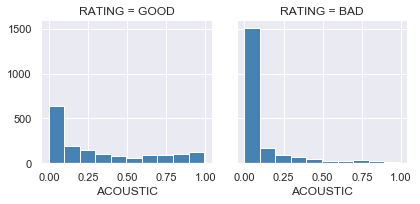

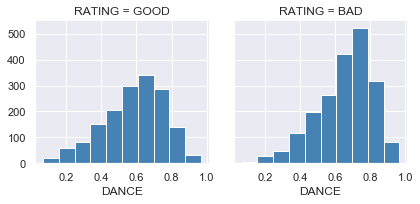

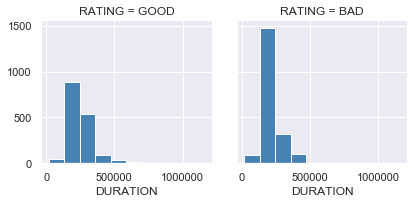

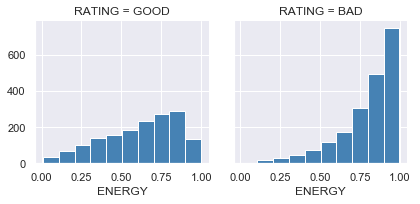

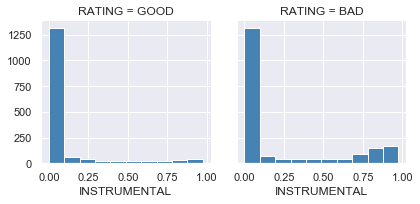

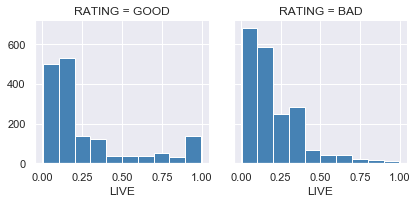

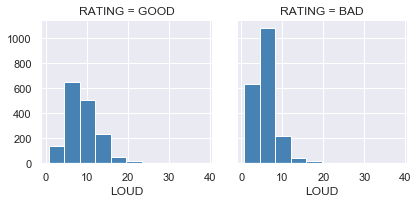

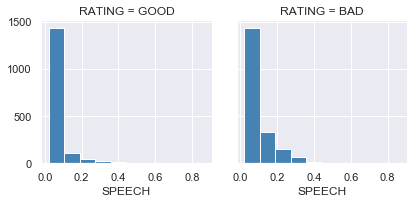

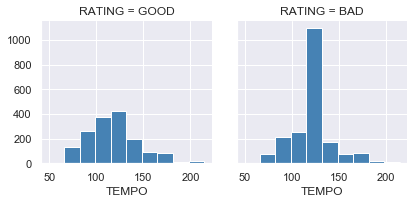

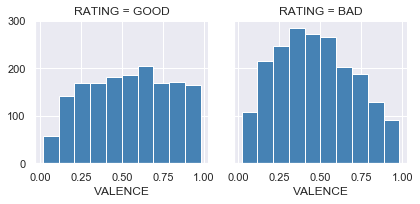

In [38]:
# construct Seaborn FacetGrid chart and compare how each data feature differ depending on ratings
sns.set(style="darkgrid")
for audio_feature in ['ACOUSTIC', 'DANCE', 'DURATION', 'ENERGY', 'INSTRUMENTAL', 'LIVE', 'LOUD', 'SPEECH', 'TEMPO', 'VALENCE']:
    count, bin_edges = np.histogram(features_df[audio_feature])
    g = sns.FacetGrid(features_df, col='RATING')
    g.map(plt.hist, audio_feature, color="steelblue", bins=bin_edges)
    plt.show()

Looking at the distributions of each feature, there are clear distinctions between my liked and disliked songs, especially in the ENERGY, DANCE, LOUD, and ACOUSTIC features.

- __Acoustic:__ I don’t like songs that are not acoustic at all.  
- __Dance:__ I prefer songs that are moderately danceable.  
- __Energy, Loud, Tempo:__ I prefer songs that are less energetic, fast and loud.  
- __Valence:__ I don't like songs that have little valence but the distribution of values in valence rate is quite equal.  

### 3.2. Feature Selection

[Feature selection](https://en.wikipedia.org/wiki/Feature_selection) is the process of selecting a subset of relevant features for use in model construction. As it turned out in previous chapter some audio features differed in greater extent over ratings that others. For this reason, only these audio features should be selected for later modeling. But as it turned out in later testing it didn't have any remarkable impact for prediction accuracy. Therefore, all audio features
are included for modeling.  

Declare the function for feature extraction.

In [39]:
def extract_features(input_df):
    """
    Extracts specified features from dataframe.
    
    :param input_df: Dataframe which needs to be extracted.
    :return: Dataframe which contains extracted features.
    """
    extracted_features_df = input_df[['ACOUSTIC', 'DANCE', 'DURATION', 'ENERGY', 'INSTRUMENTAL',
                                      'LIVE', 'LOUD', 'SPEECH', 'TEMPO', 'VALENCE']]
    return extracted_features_df

Extract the independent data features for modeling.

In [40]:
X_features_df = extract_features(features_df)
X_features_df.head(3)

,ACOUSTIC,DANCE,DURATION,ENERGY,INSTRUMENTAL,LIVE,LOUD,SPEECH,TEMPO,VALENCE
0,0.962,0.802,220507.0,0.101,0.0,0.103,13.208,0.0407,109.029,0.370
1,0.675,0.577,258507.0,0.317,0.0,0.107,10.935,0.2800,92.184,0.602
2,0.318,0.614,210507.0,0.471,0.0,0.110,6.087,0.0256,80.024,0.320


Extract the dependent data feature for modeling.

In [41]:
Y_feature_df = features_df[['RATING']]
Y_feature_df.head(3)

,RATING
0,GOOD
1,GOOD
2,GOOD


### 3.3. Data Splitting and Normalization

[Splitting the data](https://developers.google.com/machine-learning/crash-course/validation/video-lecture) into a training and test set helps to judge whether a given model will generalize well to new data.

<img src="images/WorkflowWithTestSet.png" width="500" align="left">

Split the data set into training and testing parts.

In [42]:
x_train, x_test, y_train, y_test = train_test_split(X_features_df, Y_feature_df, test_size=0.20, random_state=4)

print('Train set: '+'{} {}'.format(x_train.shape, y_train.shape))
print('Test set: '+'{} {}'.format(x_test.shape, y_test.shape))

Train set: (2896, 10) (2896, 1)
Test set: (724, 10) (724, 1)


[Data Normalization](https://blog.umetrics.com/why-preprocesing-data-creates-better-data-analytics-models) is a process of transforming values of several variables __into a similar range__. It is needed for mathematical-based algorithms to interpret variables with different magnitudes and distributions equally. Normalization gives the data __zero mean__ and __unit variance__ and is calculated by subtracting from each datapoint their mean value and then dividing by the variance.

<img src="images/normalization.png" align="left">

To avoid __Data Leakage__, it is important to remember that normalization should be carried out after splitting the data into training and testing sets. Data leakage means that information from outside the training data is used to create the model. Testing data should be unseen and accessible at the training stage. If the mean and variance is calculated from the whole data set then the future information is introduced to the training variables.

In normalization, the [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) package was used. The formula by which the standard score of a sample x is calculated is the following: 

__z = (x - u) / s__, where u is the mean of the training samples and s is the standard deviation of the training samples.

Declare the function for data normalization.

In [43]:
def normalize_data(input_df):
    """
    Normalizes all values in dataframe.
    
    :param input_df: Dataframe to be normalized.
    :return: Normalized dataframe.
    """
    normalized_df = pd.DataFrame(StandardScaler().fit_transform(input_df), columns = input_df.columns)
    return normalized_df

Normalize audio features for training data set.

In [44]:
normalized_x_train = normalize_data(x_train)
normalized_x_train.head(3)

,ACOUSTIC,DANCE,DURATION,ENERGY,INSTRUMENTAL,LIVE,LOUD,SPEECH,TEMPO,VALENCE
0,-0.705768,-1.983439,1.104880,0.949050,-0.393894,2.925918,-0.791645,-0.506682,-1.467003,-0.027716
1,0.281826,0.813724,-0.304712,-0.285565,-0.559277,-0.789725,0.790116,-0.661744,-0.104507,1.904277
2,2.207462,0.049768,-1.011505,-1.965888,-0.562119,0.425301,1.115622,-0.393671,1.384146,0.873340


Normalize audio features for testing data set.

In [45]:
normalized_x_test = normalize_data(x_test)
normalized_x_test.head(3)

,ACOUSTIC,DANCE,DURATION,ENERGY,INSTRUMENTAL,LIVE,LOUD,SPEECH,TEMPO,VALENCE
0,-0.725145,1.009868,-0.363918,0.651478,0.506258,-0.390273,-0.398017,-0.207204,0.160924,1.896967
1,-0.614260,-0.172687,-1.228097,0.743661,-0.519411,-0.163615,-0.497802,0.013100,-0.038882,1.590061
2,-0.675446,0.873419,0.811672,0.862183,-0.520250,2.455540,-0.819532,-0.287550,0.283417,1.144024


### 3.4. Prediction Metrics

There are many prediction metrics that can be used in measuring machine learning model accuracy. In this report the [Accuracy, Precision and Recall](https://medium.com/x8-the-ai-community/understanding-ml-evaluation-metrics-precision-recall-2b3fb915b666) as three well known metrics were used. 

Define the positive event that is the basis of predictions: __“Is the track listened labeled as 'GOOD'?”__

Define four types of predictions that are the basis of formulas: 

- __True Positives (TP)__ — <span style="color:green">model predicts the event is positive and that was correct.</span>  

- __False Positives (FP)__ — <span style="color:red">model predicts the event is positive but that was incorrect.</span>  

- __True Negatives (TN)__ — <span style="color:green">model predicts the event is negative and that was correct.</span>  

- __False Negatives (FN)__ — <span style="color:red">model predicts the event is negative but that was incorrect.</span>  

- __Accuracy__ - the proportion of total number of predictions that were correctly identified  

<img src="images/accuracy.JPG"/>

- __Precision__ - the proportion of positive cases that were correctly identified  

<img src="images/precision.JPG"/>

- __Recall/Sensitivity__ - the proportion of actual positive cases that were correctly identified  

<img src="images/recall.JPG"/>

### 3.5. Model Selection

To conduct a modeling, I have chosen three well known classification algorithms - Logistic Regression, K-Nearest Neighbors and Support Vector Machines. Let's find out how they can manage on quite a small data set.

#### Logistic Regression (LR)

In [46]:
# build model using LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(normalized_x_train, y_train.values.ravel())

# make prediction
y_train_pred_lr = LR.predict(normalized_x_train)
y_test_pred_lr = LR.predict(normalized_x_test)

# calculate metrics
train_accuracy_lr = round(metrics.accuracy_score(y_train, y_train_pred_lr), 6)
train_precision_lr = round(precision_score(y_train, y_train_pred_lr, average='macro'), 6)
train_recall_lr = round(recall_score(y_train, y_train_pred_lr, average='macro'), 6)

test_accuracy_lr = round(metrics.accuracy_score(y_test, y_test_pred_lr), 6)
test_precision_lr = round(precision_score(y_test, y_test_pred_lr, average='macro'), 6)
test_recall_lr = round(recall_score(y_test, y_test_pred_lr, average='macro'), 6)

train_metrics_lr = {
    'ACCURACY': train_accuracy_lr,
    'PRECISION': train_precision_lr,
    'RECALL': train_recall_lr
}
test_metrics_lr = {
    'ACCURACY': test_accuracy_lr,
    'PRECISION': test_precision_lr,
    'RECALL': test_recall_lr
}
df_lr = pd.DataFrame(test_metrics_lr, index=['Logistic Regression'])

# print the results
display(pd.DataFrame(train_metrics_lr, index=['Train set (LR)']).
        append(pd.DataFrame(test_metrics_lr, index=['Test set (LR)'])))

,ACCURACY,PRECISION,RECALL
Train set (LR),0.811809,0.812130,0.805372
Test set (LR),0.809392,0.809279,0.804241


#### K-Nearest Neighbors (KNN)

For KNN we first need to find out what is the optimum K-value that gives the best accuracy. For that lets's scan through 15 candidates and plot the accuracy for different number of neighbors.

Accuracy scores: [0.776243 0.783149 0.805249 0.80663  0.821823 0.809392 0.81768  0.825967
 0.81768  0.827348 0.824586 0.825967 0.820442 0.825967 0.819061]
Best accuracy score is for K-value 10.


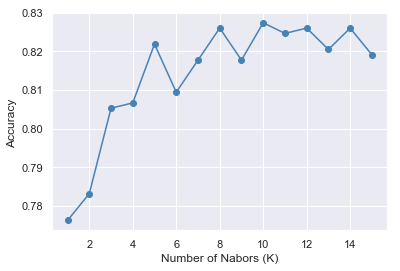

In [47]:
Ks = 16
test_acc_score_knn = np.zeros((Ks-1))

for n in range(1, Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(normalized_x_train, y_train.values.ravel())
    y_test_pred_knn = neigh.predict(normalized_x_test)
    test_acc_score_knn[n-1] = round(metrics.accuracy_score(y_test, y_test_pred_knn), 6)

print('Accuracy scores: '+'{}'.format(test_acc_score_knn))
print('Best accuracy score is for K-value '+'{}'.format(np.argmax(test_acc_score_knn)+1)+'.')

plt.plot(range(1, Ks), test_acc_score_knn, marker="o", color='steelblue', label="accuracy score")
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.show()

Since the best accuracy score was obtained by the K-value 10, let's use this for calculating all metrics for train and test data sets.

In [48]:
# build model using KNN
k = 10
neigh = KNeighborsClassifier(n_neighbors = k).fit(normalized_x_train, y_train.values.ravel())
y_train_pred_knn = neigh.predict(normalized_x_train)
y_test_pred_knn = neigh.predict(normalized_x_test)

# calculate metrics
train_accuracy_knn = round(metrics.accuracy_score(y_train, y_train_pred_knn), 6)
train_precision_knn = round(precision_score(y_train, y_train_pred_knn, average='macro'), 6)
train_recall_knn = round(recall_score(y_train, y_train_pred_knn, average='macro'), 6)

test_accuracy_knn = round(metrics.accuracy_score(y_test, y_test_pred_knn), 6)
test_precision_knn = round(precision_score(y_test, y_test_pred_knn, average='macro'), 6)
test_recall_knn = round(recall_score(y_test, y_test_pred_knn, average='macro'), 6)

train_metrics_knn = {
    'ACCURACY': train_accuracy_knn,
    'PRECISION': train_precision_knn,
    'RECALL': train_recall_knn
}
test_metrics_knn = {
    'ACCURACY': test_accuracy_knn,
    'PRECISION': test_precision_knn,
    'RECALL': test_recall_knn
}
df_knn = pd.DataFrame(test_metrics_knn, index=['K-Nearest Neighbors'])

# print the results
display(pd.DataFrame(train_metrics_knn, index=['Train set (KNN)']).
        append(pd.DataFrame(test_metrics_knn, index=['Test set (KNN)'])))

,ACCURACY,PRECISION,RECALL
Train set (KNN),0.854282,0.862081,0.845072
Test set (KNN),0.827348,0.832282,0.819391


#### Support Vector Machines (SVM)

In [49]:
# fit the model
clf = svm.SVC(kernel='rbf', gamma='auto')
clf.fit(normalized_x_train, y_train.values.ravel()) 

# predict new values
y_train_pred_svm = clf.predict(normalized_x_train)
y_test_pred_svm = clf.predict(normalized_x_test)

# calculate metrics
train_accuracy_svm = round(metrics.accuracy_score(y_train, y_train_pred_svm), 6)
train_precision_svm = round(precision_score(y_train, y_train_pred_svm, average='macro'), 6)
train_recall_svm = round(recall_score(y_train, y_train_pred_svm, average='macro'), 6)

test_accuracy_svm = round(metrics.accuracy_score(y_test, y_test_pred_svm), 6)
test_precision_svm = round(precision_score(y_test, y_test_pred_svm, average='macro'), 6)
test_recall_svm = round(recall_score(y_test, y_test_pred_svm, average='macro'), 6)

train_metrics_svm = {
    'ACCURACY': train_accuracy_svm,
    'PRECISION': train_precision_svm,
    'RECALL': train_recall_svm
}
test_metrics_svm = {
    'ACCURACY': test_accuracy_svm,
    'PRECISION': test_precision_svm,
    'RECALL': test_recall_svm
}
df_svm = pd.DataFrame(test_metrics_svm, index=['Support Vector Machines'])

# print the results
display(pd.DataFrame(train_metrics_svm, index=['Train set (SVM)']).
        append(pd.DataFrame(test_metrics_svm, index=['Test set (SVM)'])))

,ACCURACY,PRECISION,RECALL
Train set (SVM),0.866367,0.868480,0.860691
Test set (SVM),0.835635,0.834543,0.832616


### 3.6. Model Optimization

In Model Selection chapter model building was mostly done with default parameters. Traditional way in improving model’s performance is __Hyperparameter Optimization__ that is done via __Grid Search__ cross-validation. Grid Search works by searching exhaustively through a manually specified subset of hyperparameters. A __hyperparameter__ is a parameter whose value is set in algorithm initialization before the learning process begins.

In previous work the best prediction accuracy was received by SVM algorithm. Let’s try to find out if Grid Search could improve this result. For this we first explore available Grid Search parameters for specified algorithm, define their possible value ranges and then run the Grid Search.  

In [90]:
# get insights which hyperparameters are available in SVC
SVC().get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [91]:
# define hyperparameters
param_grid = {'C': (0.001, 0.01, 0.1, 1, 10),
              'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
              'class_weight': ('balanced', None),
              'gamma': ('scale', 'auto'),
              'shrinking': (True, False)}

# initialize GridSearch, setting 10-fold cross validation
grid_search = GridSearchCV(svm.SVC(), param_grid, cv=10)
# fit the model
grid_results = grid_search.fit(normalized_x_train, y_train.values.ravel())

# print the results
print('Best parameters: '+'{}'.format(grid_results.best_params_))
print('Best score: '+'{}'.format(grid_results.best_score_))

# make prediction
y_test_pred_GS = grid_results.best_estimator_.predict(normalized_x_test)
print('Prediction accuracy after GridSearch: '+'{}'.format(round(metrics.accuracy_score(y_test, y_test_pred_GS), 6)))

Best parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}
Best score: 0.8435773480662984
Prediction accuracy after GridSearch: 0.827348


As seen from the result the default settings seem to be good enough and hyperparameter tuning didn't make it better.

### 3.7. Clustering Neighborhoods

One condition in performing this certificate specialization was the usage of Foursquare API. Therefore, let's suppose we want to attend the Ed Sheeran concert at Wembley Stadium in London. In this case any suggestions about the nearby hotels would be welcome. Let's first find out the geographical coordinates of Wembley Stadium and then plot the colored circles for each hotel found in a request.

In [9]:
# find Wembley Stadium latitude and longitude
geolocator = Nominatim(user_agent='foursquare_agent')
travel_location = geolocator.geocode('Wembley Stadium')
travel_location_lat = travel_location.latitude
travel_location_lng = travel_location.longitude

In [10]:
def get_foursquare_authorization_tokens():
    """Read from file authorization tokens needed for making connection to the Foursquare API."""
    with open('datasets/foursquare_authorization.json', 'r') as f:
        fs_authorization_tokens = json.load(f)
    return fs_authorization_tokens

In [11]:
# get foursquare authorization tokens
fs_authorization_tokens = get_foursquare_authorization_tokens()
CLIENT_ID = fs_authorization_tokens.get('client_id')
CLIENT_SECRET = fs_authorization_tokens.get('client_secret')
VERSION = fs_authorization_tokens.get('version')
LIMIT = fs_authorization_tokens.get('limit')

In [12]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2000 # radius to search venues for

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, travel_location_lat, travel_location_lng, radius, LIMIT)

In [13]:
results = requests.get(url).json()
# to keep the code compact the output is commented out and shown only part of it as an image
#results

<img src="images/foursquare_request_response.JPG" align="left"/>

In [351]:
# function to extract the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [354]:
# parse the results and display first 3 rows
venues = results['response']['groups'][0]['items']
    
nearby_venues_df = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues_df =nearby_venues_df.loc[:, filtered_columns]

# filter the category for each row
nearby_venues_df['venue.categories'] = nearby_venues_df.apply(get_category_type, axis=1)

# clean columns
nearby_venues_df.columns = [col.split(".")[-1] for col in nearby_venues_df.columns]

nearby_venues_df = nearby_venues_df[nearby_venues_df['categories']=="Hotel"]
nearby_venues_df.reset_index(drop=True, inplace=True)
display(nearby_venues_df.head(10))
print('{} hotels were returned by Foursquare.'.format(nearby_venues_df.shape[0]))

,name,categories,lat,lng
0,Hilton London Wembley,Hotel,51.557566,-0.282289
1,Novotel London Wembley,Hotel,51.561280,-0.279197
2,St. George Hotel,Hotel,51.555394,-0.286257
3,Premier Inn London Wembley Park,Hotel,51.562878,-0.281058
4,Premier Inn London Wembley Stadium,Hotel,51.557282,-0.282672
5,Holiday Inn London - Wembley,Hotel,51.555713,-0.285051
6,Ibis Hotel Wembley London,Hotel,51.555085,-0.284890


7 hotels were returned by Foursquare.


In [353]:
# generate map centred around Wembley Stadium
travel_map = folium.Map(location=[travel_location_lat, travel_location_lng], zoom_start=15)

# set color scheme for the clusters
x = np.arange(nearby_venues_df.shape[0])
ys = [i + x + (i*x)**2 for i in range(nearby_venues_df.shape[0])]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add hotel's spots to the map as colored circle markers
for lat, lng, label, venue_ind in zip(nearby_venues_df.lat, nearby_venues_df.lng, nearby_venues_df.name, nearby_venues_df.index.tolist()):
    circle_marker = folium.CircleMarker(
            [lat, lng],
            radius=10,
            popup=label,
            fill=True,
            color=rainbow[venue_ind],
            fill_color=rainbow[venue_ind],
            fill_opacity=0.6
            ).add_to(travel_map)

# display map
travel_map

## 4. Results

### 4.1. Algorithms Comparison

After summarizing prediction results of three different algorithms, the following dataframe can be constructed. The best classifier is __Support Vector Machines__, but there is very little difference with K-Nearest Neighbors. 

In [50]:
# join all three dataframes
df_all = df_lr.append(df_knn).append(df_svm)
# sort values, best results first
df_all.sort_values(['ACCURACY'], ascending=False, axis=0, inplace=True)
# highlight rows in different colours
df_all.style.apply(lambda x: ["color: green" if v==x.iloc[0] 
                              else ("color: orange" if v==x.iloc[1] else "color: red")
                              for v in x], axis=0)

,ACCURACY,PRECISION,RECALL
Support Vector Machines,0.835635,0.834543,0.832616
K-Nearest Neighbors,0.827348,0.832282,0.819391
Logistic Regression,0.809392,0.809279,0.804241


### 4.2. ROC AUC Curve

In order to compare one model to another, the [AUC ROC](https://towardsdatascience.com/understanding-the-roc-and-auc-curves-a05b68550b69) curve needs to be constructed. __AUC__ (Area Under The Curve) __ROC__ (Receiver Operating Characteristics) __curve__ is a performance measure at various thresholds settings. ROC is a probability curve and AUC degree of separability. ROC curves are obtained by plotting the __True Positive__ rate against the __False Positive__ rate and the performance is usually measured by the area under the ROC curve. Thus, it shows the model’s capability to distinguish the difference between classes.

In [51]:
# convert categorical labels to numerical values
y_test_rc = y_test['RATING'].apply(lambda x: 1 if x=='GOOD' else 0)
y_pred_svm_rc = np.where(y_test_pred_svm=='GOOD', 1, 0)
y_pred_knn_rc = np.where(y_test_pred_knn=='GOOD', 1, 0)
y_pred_lr_rc = np.where(y_test_pred_lr=='GOOD', 1, 0)

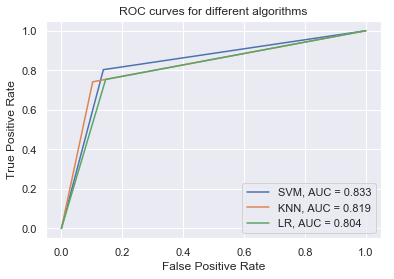

In [52]:
# calculate 'False Positive', 'True Positive' and Threshold scores
FP_rate_svm, TP_rate_svm, thresholds_svm = roc_curve(y_test_rc, y_pred_svm_rc)
FP_rate_knn, TP_rate_knn, thresholds_knn = roc_curve(y_test_rc, y_pred_knn_rc)
FP_rate_lr, TP_rate_lr, thresholds_lr = roc_curve(y_test_rc, y_pred_lr_rc)

# calculate AUC scores
roc_auc_svm = auc(FP_rate_svm, TP_rate_svm)
roc_auc_knn = auc(FP_rate_knn, TP_rate_knn)
roc_auc_lr = auc(FP_rate_lr, TP_rate_lr)

# plot the curves
plt.plot(FP_rate_svm, TP_rate_svm, label='{}, AUC = {:.3f}'.format('SVM', roc_auc_svm))
plt.plot(FP_rate_knn, TP_rate_knn, label='{}, AUC = {:.3f}'.format('KNN', roc_auc_knn))
plt.plot(FP_rate_lr, TP_rate_lr, label='{}, AUC = {:.3f}'.format('LR', roc_auc_lr))

# set styling parameters
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for different algorithms')
plt.legend(loc="lower right")
plt.show()

In this case the __best AUC by SVM was 83.3%__, indicating a good level of prediction accuracy to distinguish a good musical track from bad one. Since there were only two values (GOOD or BAD) in ratings category, the ROC curve is triangle shaped.

### 4.3. Model Evaluation

Partitioning data into the training and test sets may be insufficient when doing many rounds of testing and hyperparameter tuning. Doing many iterations where model is trained, tested, metrics observed and parameters adjusted until the best possible model is found, may result to __[overfit](https://elitedatascience.com/overfitting-in-machine-learning)__ to the peculiarities of test data.

One solution to handle this, is to create a third data set out of previous two partitions. In this way created classifier is evaluated only on this data set. I have chosen a way where data for the final test contains ten musical genres from playlists not used in training. One track from each of them is included for evaluation, a dataframe with appropriate audio features constructed and then predictions made. For data labeling, I listened to all ten tracks and rated them as a 'GOOD' or 'BAD' one.

In [85]:
# get data
evaluation_pl_df = pd.read_csv("datasets/sp_evaluation_dataset.csv", 
                          encoding='utf-8',
                          sep="\t", 
                          thousands=",")
evaluation_pl_df.head(3)

,genre,artist,title,actual_rating
0,Afro,Juliana,Tony Okoroji,GOOD
1,Country,Keith Whitley,It Ain't Nothin',GOOD
2,Electronic,J Balvin,Positivo,BAD


In [86]:
user_playlists = get_user_playlists()
genres_playlist_names = list(evaluation_pl_df['genre'])
audio_features = pd.DataFrame()

for playlist_id, playlist_name in user_playlists.items():
    if genres_playlist_names.__contains__(playlist_name):
        playlist_tracks = get_playlist_tracks(sp_authorization_tokens.get('username'), playlist_id, False)
        audio_features = audio_features.append(get_audio_features(playlist_tracks).drop(['artist', 'title'], axis=1), ignore_index=True, sort=False)
    else:
        continue

evaluation_pl_df = pd.concat([evaluation_pl_df, audio_features], axis=1)
evaluation_pl_df.head(3)

,genre,artist,title,actual_rating,acousticness,analysis_url,danceability,duration_ms,energy,id,...,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,Afro,Juliana,Tony Okoroji,GOOD,0.116000,https://api.spotify.com/v1/audio-analysis/5QVr...,0.690,336440.0,0.868,5QVr1U4qIpdYIWOzAjbXfr,...,0.338,-12.148,1.0,0.0550,101.432,4.0,https://api.spotify.com/v1/tracks/5QVr1U4qIpdY...,audio_features,spotify:track:5QVr1U4qIpdYIWOzAjbXfr,0.784
1,Country,Keith Whitley,It Ain't Nothin',GOOD,0.148000,https://api.spotify.com/v1/audio-analysis/7fYK...,0.610,244333.0,0.683,7fYKKFD0jiSlMDgG9IUs1q,...,0.157,-11.549,0.0,0.0458,138.695,4.0,https://api.spotify.com/v1/tracks/7fYKKFD0jiSl...,audio_features,spotify:track:7fYKKFD0jiSlMDgG9IUs1q,0.610
2,Electronic,J Balvin,Positivo,BAD,0.000811,https://api.spotify.com/v1/audio-analysis/4HUq...,0.373,183773.0,0.937,4HUqrGAZ5f0gHRor7z9BFc,...,0.815,-2.133,0.0,0.0834,150.242,4.0,https://api.spotify.com/v1/tracks/4HUqrGAZ5f0g...,audio_features,spotify:track:4HUqrGAZ5f0gHRor7z9BFc,0.460


In [87]:
# clean data
evaluation_pl_df = clean_df(evaluation_pl_df, True)

# extract features
X_evaluation_features_df = extract_features(evaluation_pl_df)

# normalize features
n_X_evaluation_features_df = normalize_data(X_evaluation_features_df)
display(n_X_evaluation_features_df.head(3))

0 duplicate rows removed.


,ACOUSTIC,DANCE,DURATION,ENERGY,INSTRUMENTAL,LIVE,LOUD,SPEECH,TEMPO,VALENCE
0,-0.286195,0.625458,0.499024,0.892218,-0.473053,0.477949,0.603033,-0.270228,-0.867193,1.464335
1,-0.179105,0.083936,-0.300844,0.089786,1.660377,-0.385325,0.478916,-0.504544,0.622271,0.414503
2,-0.671683,-1.520324,-0.826754,1.191504,-0.579774,2.752986,-1.472139,0.453096,1.083824,-0.490525


In [88]:
# set predicted ratings
evaluation_pl_df['PREDICTED_RATING'] = clf.predict(n_X_evaluation_features_df)

# set music style as an index
evaluation_pl_df.set_index('GENRE', inplace=True)
del evaluation_pl_df.index.name

# set 'VERIFICATION' column values
evaluation_pl_df['VERIFICATION'] = list(map(lambda x:str(x).upper(), 
                                          list(evaluation_pl_df['ACTUAL_RATING'].eq(evaluation_pl_df['PREDICTED_RATING']))))

# take subset of sorted dataframe and set styling for 'VERIFICATION' column
evaluation_pl_df = (evaluation_pl_df.loc[:, ('ARTIST', 'TITLE', 'ACTUAL_RATING', 'PREDICTED_RATING', 'VERIFICATION')]).sort_index()

# highlight 'VERIFICATION' column depending on values
evaluation_pl_df.style.apply(lambda x: ['color: green' if i=='TRUE'
                                  else ('color: red' if i=='FALSE' else '') for i in x], axis=0)

,ARTIST,TITLE,ACTUAL_RATING,PREDICTED_RATING,VERIFICATION
Afro,Juliana,Tony Okoroji,GOOD,GOOD,TRUE
Country,Keith Whitley,It Ain't Nothin',GOOD,BAD,FALSE
Electronic,J Balvin,Positivo,BAD,BAD,TRUE
Hip-Hop,DaBaby,Suge,BAD,BAD,TRUE
Indie,Tame Impala,Borderline,GOOD,GOOD,TRUE
Jazz,The Dave Brubeck Quartet,Take Five,GOOD,GOOD,TRUE
Metal,Jorn,Blacksong,BAD,BAD,TRUE
Pop,Lady Gaga,Shallow - Radio Edit,GOOD,BAD,FALSE
Rock,Dire Straits,Sultans of Swing,GOOD,GOOD,TRUE
Soul,Rufus,Ain't Nobody,GOOD,GOOD,TRUE


In [89]:
# calculate prediction scores
accuracy_evaluation = metrics.accuracy_score(evaluation_pl_df['ACTUAL_RATING'], evaluation_pl_df['PREDICTED_RATING'])
precision_evaluation = precision_score(evaluation_pl_df['ACTUAL_RATING'], evaluation_pl_df['PREDICTED_RATING'], average='macro')
recall_evaluation = recall_score(evaluation_pl_df['ACTUAL_RATING'], evaluation_pl_df['PREDICTED_RATING'], average='macro')

print('ACCURACY: '+'{}'.format(round(accuracy_evaluation, 6))+
      ', PRECISION: '+'{}'.format(round(precision_evaluation, 6))+
      ', RECALL: '+'{}'.format(round(recall_evaluation, 6)))

ACCURACY: 0.8, PRECISION: 0.8, RECALL: 0.857143


Since the model fits to the training set slightly better than to the evaluation set, some overfitting may exist in the model. But as the cap is quite small and the accuracy score is still good, __we can consider the project successful.__

## 5. Discussion

Doing a real data science project was very helpful in practicing topics learned in the course and also finding new tips & tricks for many complicated tasks. Most time-consuming part in this project was definitely data acquiring and cleaning. And before that also finding the project subject that could from one side be interesting to yourself and on the other hand be supported by the necessary data. The fact if the data has enough meaning at all for later modeling will often come out after a lot of work has been already done in data preparation.

Although the model's prediction capability was good the next steps could be considered in further developments if there is a desire to improve the results:

- Increase the data set  
- Try different proportions between liked and disliked playlists  
- Try different normalization methods  
- Try different modeling algorithms  

## 6. Conclusion

The key factors that I can conclude from this project are:

- Most important audio features that determine my musical taste are Acousticness, Danceability, Energy and Valence.
- I prefer Country, Indie, Jazz, Pop, Rock, Soul and Afro music but Electronic, Hip-Hop and Metal are not so much in my favor.
- The best classifier was Support Vector Machines and the model optimization didn’t give any better results.
- Always normalize data before modeling. The difference in prediction accuracy with normalized and not normalized data was depending on the algorithm up to a twenty percentage point.  
- Despite the quite small dataset the prediction model I created achieved a good level of prediction accuracy.   